# Import

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import operator
import pprint
import sklearn
# import community
from sklearn import metrics
from sklearn import cluster
import pandas as pd
import sys

In [27]:
df = pd.read_csv('../data/filtered.csv')
print df.head()
print df.info()

   Source  Target  posting  grade  anal  oral  kiss
0       0       1        0      0     0     0     0
1       0      12      216      0     0     0     0
2       0      34      223      0     0     0     0
3       0      43      245      0     0     0     0
4       0      45      252      0     0     0     0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31878 entries, 0 to 31877
Data columns (total 7 columns):
Source     31878 non-null int64
Target     31878 non-null int64
posting    31878 non-null int64
grade      31878 non-null int64
anal       31878 non-null int64
oral       31878 non-null int64
kiss       31878 non-null int64
dtypes: int64(7)
memory usage: 1.7 MB
None


In [28]:
female = {}
male = {}

for idx, row in df.iterrows():
    fe = row['Source']
    ma = row['Target']
    if fe in female:
        female[fe] = female[fe] + 1;
    else:
        female[fe] = 1
    
    if ma in male:
        male[ma] = male[ma] + 1;
    else:
        male[ma] = 1

print "Escort", len(female), "Buyer", len(male), "Total", len(female) + len(male)


Escort 3728 Buyer 5420 Total 9148


# Init Data

In [29]:
# 1st column: Female-id
# 2nd column: Male-id
# 3rd column: Date (in days) of posting
# 4th column: Female grade given by the male (Bad: -1 Neutral: 0  Good: +1)
# 5th column: Anal sex with/without condom?  (Yes: +1  No: -1  Information not available: 0)
# 6th column: Oral sex with condom?          (Yes: +1  No: -1  Information not available: 0)
# 7th column: Mouth kiss?                    (Yes: +1  No: -1  Information not available: 0)

# a new empty graph object
G = nx.Graph()
Females_Full = []
Males_Full = []

def add_node_to_graph(val, num):
    try:
        # Check if value is in graph
        G.node[val]
    except:
        # Add if there is a null pointer
        G.add_nodes_from([val], bipartite=num);
    

# Add data to list and graph
for idx, row in df.iterrows():
    # From
    fr = row['Source']
    Females_Full.append(fr)
    # To
    to = row['Target']
    Males_Full.append(to)
    
    # Attributes
    posting = row['posting']
    grade = row['grade']
    anal = row['anal']
    oral = row['oral']
    kiss = row['kiss']
    
    # Add Nodes
    add_node_to_graph(fr, 0)
    add_node_to_graph(to, 1)

    # Add edges
    G.add_edges_from([(fr, to)], posting=posting, grade=grade, anal=anal, oral=oral, kiss=kiss)

# Create Giant Component
giant = max(nx.connected_component_subgraphs(G), key=len)

# Gather Info

# HW1

In [7]:
def print_info(g):
    print nx.info(g)
    
    print "Number of Connected Componenets:", (nx.number_connected_components(g))
    
    print "Is graph Bipartide", nx.is_bipartite(g)
    
    print "Is graph Directed", nx.is_directed(g)
    print_in_out_degree(g)
    print_graph_components(g)
    print_components(g)
    
    print "Is graph Connected", nx.is_connected(g)
    print
    print_measurments(g)
    print_path_info(g)


In [8]:
# Used if is directed
def print_in_out_degree(g):
    if (nx.is_directed(g)):
        print "In degree:", g.in_degree()
        print "In degree:", g.out_degree()
        print

In [9]:
def print_graph_components(g):
    if(nx.is_directed(g)):
        print "Is graph Semi Connected", nx.is_semiconnected(g)
        print "Is graph Attracting Components", nx.is_attracting_component(g)
        print

In [10]:
def print_components(g):
    if(nx.is_directed(g)):
        sg = nx.strongly_connected_components(g)
        print_component_list(sg, "Strongly")
        sg = nx.weakly_connected_components(g)
        print_component_list(sg, "Weakly")

def print_component_list(sg, connected_type):
    print connected_type, "Connected Components:"
    print [list(l) for l in sg]
    print

In [11]:
def print_measurments(g):
    print "Density:", nx.density(g)
    print "Size:", g.size()
#     print "Center", nx.center(G)
#     print "Radius", nx.radius(G)
    print

In [12]:
def print_path_info(g):
#     print "Shortest Path:", nx.shortest_path(g)
    print "Average Shortest Path:", nx.average_shortest_path_length(g)
    print "Diameter (Longest Shortest Path):", nx.diameter(g)
    print

In [13]:
def print_clustering(g):
    print "Average Clustering Coefficient:", nx.average_clustering(g)
    dc = nx.clustering(g)
    sorted_dc = sorted(dc.items(), key=operator.itemgetter(1), reverse=True)
    print "Top Cluster", (sorted_dc[0])
    print "Bottom Cluster", (sorted_dc[len(sorted_dc) - 1])
#     pprint.pprint(sorted_dc)
    print

In [14]:
def print_top_bottom_centerality(g):
    dc = nx.degree_centrality(g)
    print_dc(dc, "")
    
    dc = nx.betweenness_centrality(g)
    print_dc(dc, "Betweenness")
    
    dc = nx.edge_betweenness_centrality(g)
    print_dc(dc, "Betweenness Edge")
    
    dc = nx.closeness_centrality(g)
    print_dc(dc, "Closeness")

    
def print_dc(dc, type_dc):
    sorted_dc = sorted(dc.items(), key=operator.itemgetter(1), reverse=True)
    print "Top Degree", type_dc, "Centerality", (sorted_dc[0])
    print "Bottom Degree", type_dc, "Centerality", (sorted_dc[len(sorted_dc) - 1 ])
#     pprint.pprint(sorted_dc)
    print

In [15]:
def print_loglog_graph(g):
    degree_sequence = sorted(nx.degree(g).values(),reverse=True)
    plt.loglog(degree_sequence,'b-',marker='o')
    plt.title('Degree rank plot')
    plt.ylabel('degree')
    plt.xlabel('rank')

# HW2

 # Link Analysis

In [16]:
def print_page_rank(g):
    pr = nx.pagerank(g)
    sorted_pr = sorted(pr.items(), key=operator.itemgetter(1), reverse=True)
    
    print "Top Page Rank", (sorted_pr[0])
    print "Bottom Page Rank", (sorted_pr[len(sorted_pr) - 1 ])
    
    print

In [17]:
def print_hits(g):
    h,a=nx.hits(g)
    sorted_h = sorted(h.items(), key=operator.itemgetter(1), reverse=True)
    sorted_a = sorted(a.items(), key=operator.itemgetter(1), reverse=True)
    
    print "Top Hub", (sorted_h[0])
    print "Bottom Hub", (sorted_h[len(sorted_h) - 1 ])

    print "\n"

    print "Top Authority", (sorted_a[0])
    print "Bottom Authority", (sorted_a[len(sorted_a) - 1 ])
    
    print

# Node Centric

In [18]:
def print_clique_info(g, k):
#     cl = list(nx.enumerate_all_cliques(g))
    # print last 10 cliques
#     print "Last 10 cliques out of:", len(cl)
#     print [l for l in cl][-10:]
#     print 
    
    # search for all max_cliques in Graph G
    found_cliques = list(nx.find_cliques(g))
    print "All max cliques out of:", len(found_cliques)
#     print [l for l in found_cliques]
    print

    
    # number of cliques containg node G
    # nx.cliques_containing_node(G, node_label)
    print ""
    print nx.cliques_containing_node(g, 1)
    print
    

In [19]:
def print_k_cliques(g, k):
    # Find k cliques using percolation method
#     K5 = nx.convert_node_labels_to_integers(g, first_label=2)
#     g.add_edges_from(K5.edges())
    c = list(nx.k_clique_communities(g, k))
    print "Percolation Method"
    print "Found", len(c), " " + str(k) + "-cliques"
    pprint.pprint(c)


In [20]:
def print_k_core(g, k):
    g_k = nx.k_core(g, k=k)
    nx.draw(g_k)

# Group Centric

In [21]:
# TODO: Can not find code

# Network Centric

In [22]:
def print_vector_similarity (g):
    cos_sim = sklearn.metrics.pairwise.cosine_similarity(nx.adjacency_matrix(g))
    jac_sim = sklearn.metrics.jaccard_similarity_score(nx.adjacency_matrix(g)[0, :], nx.adjacency_matrix(g)[1, :])
    
    print "Cos Similarity", cos_sim
    print
    print "Jac Similarity", jac_sim
    print
    

In [23]:
def print_kmeans(g):
    kmeans_model = cluster.KMeans(n_clusters=8)
    kmeans_model.fit(nx.adjacency_matrix(g))

    # prin the first cluster center
    kmeans_model.cluster_centers_[1, :]
    print kmeans_model.labels_
    print

# Community

In [24]:
def print_dendrogram(g):
    dendrogram = community.generate_dendrogram(G)
    print "Partition Levels:", len(dendrogram)
    for level in range(len(dendrogram) - 1):
        print("partition at level", level, "is")  # NOQA
        lv = (community.partition_at_level(dendrogram, level))
        sorted_lv = sorted(lv.items(), key=operator.itemgetter(1), reverse=True)
        pprint.pprint(sorted_lv)
        print


In [36]:
def print_community(g):
    #better with karate_graph() as defined in networkx example.
    #erdos renyi don't have true community structure
    #first compute the best partition
    partition = community.best_partition(g) # Compute the partition of the graph nodes which maximises the modularity (or try..) using the Louvain heuristices
    print("Modularity", community.modularity(partition, g))


    #drawing
    size = float(len(set(partition.values())))
    pos = nx.spring_layout(g)
    count = 0.
    for com in set(partition.values()) :
        count = count + 1.
        list_nodes = [nodes for nodes in partition.keys()
                                    if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                    node_color = str(count / size))


    nx.draw_networkx_edges(g,pos, alpha=0.5)
    plt.show()

# Information Cascade

In [26]:
# TODO: No Code

# Full Graph

In [30]:
print_info(G)

Name: 
Type: Graph
Number of nodes: 9148
Number of edges: 31878
Average degree:   6.9694
Number of Connected Componenets: 1
Is graph Bipartide True
Is graph Directed False
Is graph Connected True

Density: 0.000761932023273
Size: 31878

Average Shortest Path: 5.18033638876
Diameter (Longest Shortest Path): 15



In [31]:
print_clustering(G)

Average Clustering Coefficient: 0.0
Top Cluster (0, 0.0)
Bottom Cluster (16703, 0.0)



In [32]:
print_top_bottom_centerality(G)

Top Degree  Centerality (4569, 0.028096643708319668)
Bottom Degree  Centerality (16656, 0.00010932546190007652)

Top Degree Betweenness Centerality (4585, 0.043413136800205705)
Bottom Degree Betweenness Centerality (16656, 0.0)

Top Degree Betweenness Edge Centerality ((1599, 10964), 0.016653964786527756)
Bottom Degree Betweenness Edge Centerality ((5727, 7731), 7.483865334683727e-06)

Top Degree Closeness Centerality (4585, 0.28389199255121045)
Bottom Degree Closeness Centerality (16585, 0.08652918361555198)



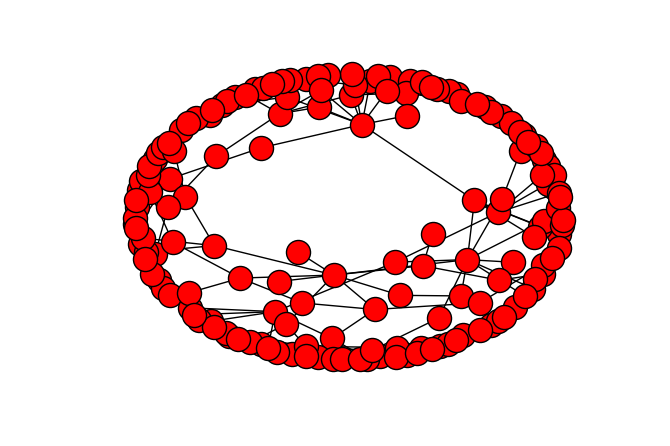

In [165]:
nx.draw(G)

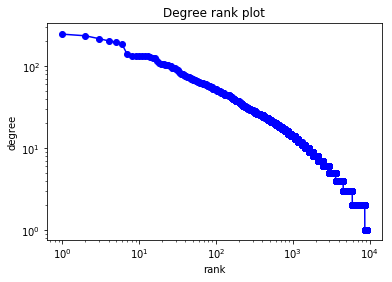

In [33]:
print_loglog_graph(G)

In [40]:
pprint.pprint(G.edges(data=True))

[(0, 5248, {'anal': 0, 'grade': 0, 'kiss': 1, 'oral': -1, 'posting': 1413}),
 (0, 1, {'anal': 0, 'grade': 0, 'kiss': 0, 'oral': 0, 'posting': 0}),
 (0, 940, {'anal': 0, 'grade': 0, 'kiss': 0, 'oral': 0, 'posting': 627}),
 (0, 12, {'anal': 0, 'grade': 0, 'kiss': 0, 'oral': 0, 'posting': 216}),
 (0, 145, {'anal': 0, 'grade': 0, 'kiss': 0, 'oral': 0, 'posting': 357}),
 (0, 7828, {'anal': 1, 'grade': 1, 'kiss': 1, 'oral': 1, 'posting': 1620}),
 (0, 1991, {'anal': 1, 'grade': 1, 'kiss': -1, 'oral': -1, 'posting': 837}),
 (0, 8585, {'anal': 1, 'grade': 1, 'kiss': 1, 'oral': -1, 'posting': 1463}),
 (0, 34, {'anal': 0, 'grade': 0, 'kiss': 0, 'oral': 0, 'posting': 223}),
 (0, 11173, {'anal': 1, 'grade': 1, 'kiss': 1, 'oral': -1, 'posting': 1700}),
 (0, 425, {'anal': 0, 'grade': 0, 'kiss': 0, 'oral': 0, 'posting': 500}),
 (0, 43, {'anal': 0, 'grade': 0, 'kiss': 0, 'oral': 0, 'posting': 245}),
 (0, 812, {'anal': 0, 'grade': 0, 'kiss': 0, 'oral': 0, 'posting': 603}),
 (0, 45, {'anal': 0, 'grade': 

In [41]:
print_vector_similarity(G)

Cos Similarity [[ 1.          0.          0.19451951 ...,  0.          0.          0.        ]
 [ 0.          1.          0.         ...,  0.          0.          0.        ]
 [ 0.19451951  0.          1.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  1.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          1.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          1.        ]]

Jac Similarity 0.0



In [42]:
print_page_rank(G)

Top Page Rank (4569, 0.0029357206186875393)
Bottom Page Rank (7916, 2.561317676457188e-05)



In [43]:
print_hits(G)

Top Hub (370, 0.004429594841681599)
Bottom Hub (16585, 2.890336027697638e-15)


Top Authority (4569, 0.009098827681201287)
Bottom Authority (16585, 1.8044436295858464e-15)

